# <center> **PROJECT-3. Анализ воронки**

***

## <left> ЦЕЛИ
Исследовать поведение пользователей в обновлённом приложении.

## <left> ЗАДАЧИ
В рамках проверки гипотез вам необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Перед началом работы обработаем данные:
- Выделим группу пользователей, которые зарегистрировались в 2018 году;
- Объединим данные о действиях пользователей и покупках в один датасет.

In [2]:
events_df = pd.read_csv('data/events.csv', sep=',')
purchase_df = pd.read_csv('data/purchase.csv', sep=',')
# Выделяем список Id пользователей зарегистрировавшихся в 2018 году
user_list = list(events_df[(events_df['start_time'] < '2019-01-01') & (events_df['start_time'] >= '2018-01-01') & (events_df['event_type'] == 'registration')]['user_id'])
# Фильтруем данные по пользователям 
events_df = events_df[events_df['user_id'].isin(user_list)]
purchase_df = purchase_df[purchase_df['user_id'].isin(user_list)]
# Объединяем датасеты
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})
purchase_df.start_time = purchase_df.start_time.apply(lambda x: str(x).replace('T', ' '))

total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

#Рассмотрим результрирующую таблицу
display(total_events_df[total_events_df.event_type == 'purchase'].head(10))

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
66959,NaN,purchase,NaN,2018-01-03 18:53:43,NaN,27845,16845.0,100.0
66960,NaN,purchase,NaN,2018-01-04 14:46:10,NaN,27865,16846.0,250.0
66961,NaN,purchase,NaN,2018-01-07 08:19:12,NaN,27911,16848.0,50.0
66962,NaN,purchase,NaN,2018-01-07 12:11:34,NaN,27910,16849.0,100.0
66963,NaN,purchase,NaN,2018-01-07 13:16:41,NaN,27940,16850.0,200.0
66964,NaN,purchase,NaN,2018-01-07 22:55:33,NaN,27965,16851.0,100.0
66965,NaN,purchase,NaN,2018-01-07 23:20:25,NaN,27981,16852.0,50.0
66966,NaN,purchase,NaN,2018-01-08 01:18:23,NaN,27969,16853.0,100.0
66967,NaN,purchase,NaN,2018-01-08 19:37:34,NaN,27884,16854.0,150.0
66968,NaN,purchase,NaN,2018-01-09 14:09:18,NaN,27977,16855.0,25.0


# <left> **ГИПОТЕЗА №1**

## Суть гипотезы
Определите, насколько обучение сокращает время прохождения этапов игры.

### ШАГИ
* 1 Разделить `пользователей` на две группы:
    - те, кто завершил обучение;
    - те, кто не завершил обучение.
* 2 Посчитать время прохождения `этапов` для каждой из групп


C:\Users\Nata\AppData\Local\Temp\ipykernel_6244\1247908999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_level_ch_df.start_time = pd.to_datetime( reg_level_ch_df.start_time )
C:\Users\Nata\AppData\Local\Temp\ipykernel_6244\1247908999.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_ch_pack_ch_df["start_time"] = pd.to_datetime( level_ch_pack_ch_df["start_time"] )
C:\Users\Nata\AppData\Local\Temp\ipykernel_6244\1247908999.py:31: SettingWithCopyWarning: 
A value is trying to be set on a co

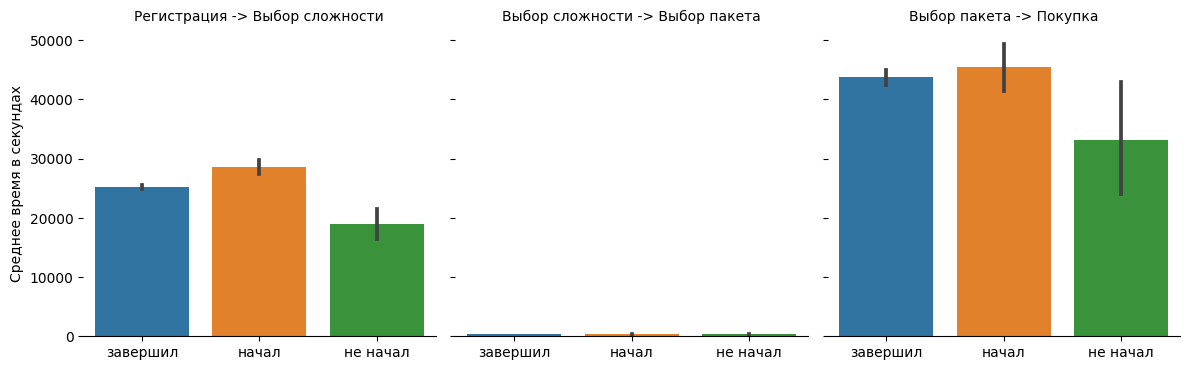

In [3]:
# Определяем множестов пользователей, которые завершили обучение
users_w_tutorial = set(total_events_df[total_events_df["event_type"] == 'tutorial_finish']['user_id'].unique())
# Определяем множество пользователей, которые начали, но не завершили обучение
users_w_stutorial = set(total_events_df[(total_events_df["event_type"] == 'tutorial_start') & (~total_events_df["user_id"].isin(users_w_tutorial))]['user_id'].unique())
# Определяем множество пользователей, которые не начинали обучение 
users_wo_tutorial = set(total_events_df[(~total_events_df["user_id"].isin(users_w_tutorial)) & (~total_events_df["user_id"].isin(users_w_stutorial))]['user_id'].unique())
# Выделяем каждый этап в датасет со временем начала
# Регистрация - Выбор уровня сложности
# Выбираем тип события Регистрация и Выбор уровня сложности
reg_level_ch_df = total_events_df[(total_events_df["event_type"] == "registration") | (total_events_df["event_type"] == "level_choice")]
reg_level_ch_df.start_time = pd.to_datetime( reg_level_ch_df.start_time )  
# Определяем первые значиения по каждому событию и пользователю
reg_level_ch_diff = reg_level_ch_df.groupby(['user_id', 'event_type'], as_index=False)['start_time'].min().sort_values(['user_id', 'start_time'])
# Находим разницу между событиями Регистрация - Выбор сложности
reg_level_ch_diff['deltatime'] = reg_level_ch_diff.groupby(['user_id'])['start_time'].diff().dt.seconds.fillna(0)
# Распределяем пользователей по группам, кто завершил обучение, кто начал, и кто не начинал
reg_level_ch_diff['user_tutorial_stat'] = reg_level_ch_diff["user_id"].apply(lambda x: 'завершил' if x in users_w_tutorial else 'начал' if x in users_w_stutorial else 'не начал') 
delta_time_reg_level_diff = reg_level_ch_diff[reg_level_ch_diff.deltatime > 0][['user_id', 'event_type', 'deltatime', 'user_tutorial_stat']]
# Устанавливаем для разниц значение Регистрация - выбор сложности
delta_time_reg_level_diff["event_type"] = 'Регистрация -> Выбор сложности'

level_ch_pack_ch_df = total_events_df[(total_events_df["event_type"] == "level_choice") | (total_events_df["event_type"] == "pack_choice")]
level_ch_pack_ch_df["start_time"] = pd.to_datetime( level_ch_pack_ch_df["start_time"] )  
level_ch_pack_ch_diff = level_ch_pack_ch_df.groupby(['user_id', 'event_type'], as_index=False)['start_time'].min().sort_values(['user_id', 'start_time'])
level_ch_pack_ch_diff['deltatime'] = level_ch_pack_ch_diff.groupby(['user_id'])['start_time'].diff().dt.seconds.fillna(0)
level_ch_pack_ch_diff['user_tutorial_stat'] = level_ch_pack_ch_diff["user_id"].apply(lambda x: 'завершил' if x in users_w_tutorial else 'начал' if x in users_w_stutorial else 'не начал') 
delta_time_level_pack_diff = level_ch_pack_ch_diff[level_ch_pack_ch_diff["deltatime"] > 0][['user_id', 'event_type', 'deltatime', 'user_tutorial_stat']]
delta_time_level_pack_diff["event_type"] = 'Выбор сложности -> Выбор пакета'

pack_ch_purch_df = total_events_df[(total_events_df["event_type"] == "pack_choice") | (total_events_df["event_type"] == "purchase")]
pack_ch_purch_df["start_time"] = pd.to_datetime( pack_ch_purch_df["start_time"] )  
pack_ch_purch_diff = pack_ch_purch_df.groupby(['user_id', 'event_type'], as_index=False)['start_time'].min().sort_values(['user_id', 'start_time'])
pack_ch_purch_diff['deltatime'] = pack_ch_purch_diff.groupby(['user_id'])['start_time'].diff().dt.seconds.fillna(0)
pack_ch_purch_diff['user_tutorial_stat'] = pack_ch_purch_diff["user_id"].apply(lambda x: 'завершил' if x in users_w_tutorial else 'начал' if x in users_w_stutorial else 'не начал') 
delta_time_pack_purch_diff = pack_ch_purch_diff[pack_ch_purch_diff.deltatime > 0][['user_id', 'event_type', 'deltatime', 'user_tutorial_stat']]
delta_time_pack_purch_diff["event_type"] = 'Выбор пакета -> Покупка'

#Объединяем все значения в один датасет
all_delta_time = pd.concat([delta_time_reg_level_diff,
                            delta_time_level_pack_diff,
                            delta_time_pack_purch_diff], sort=False)

# Строим график
g=sns.catplot( data=all_delta_time,
               kind='bar',
               x='user_tutorial_stat', 
               y='deltatime',
               col='event_type',
               height=4)
g.despine(left=True)
g.set_axis_labels("", "Среднее время в секундах")
g.set_titles("{col_name}") 

#### Выводы по гипотезе №1
Из графика видно, что пользователе, которые проходили обучение тратят значительно больше времени чем те кто не проходил. Возможно это связано с тем, что некоторые пользователи проходят обучение несколько раз и потом покупают пакеты, поэтому разница между первым прохождением обучения и покупкой большая.
***

# <left> **ГИПОТЕЗА №2**

## Суть гипотезы
Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь?

### ШАГИ
* 1 Выделить `пользователей`, которые делали `покупки` пакетов;
* 2 Посчитать кол-во начатых и кол-во завершенных `обучений`.


Text(0.5, 1.0, 'Кол-во пройденых обучений')

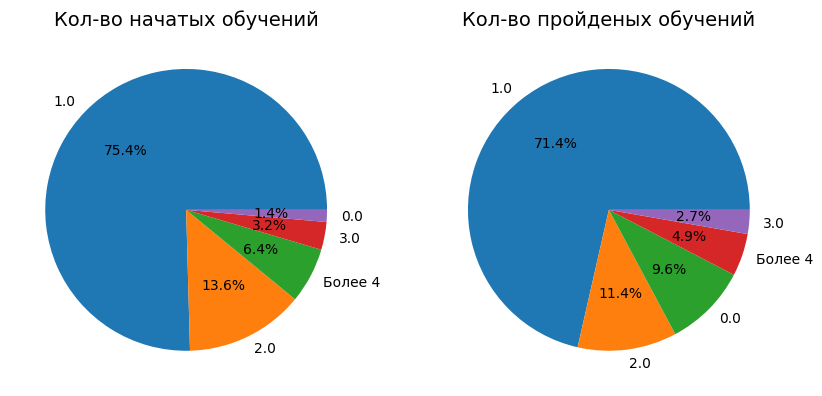

In [4]:
# Определяем пользователей с покупками
users_w_purchase_set = set(total_events_df[total_events_df["event_type"] == 'purchase']['user_id'].unique())
# Считаем кол-во начатых обучений для каждого пользователя
user_start_tutorial = total_events_df[(total_events_df["event_type"] == 'tutorial_start') & (total_events_df.user_id.isin(users_w_purchase_set))].groupby('user_id', as_index=False).count()
user_start_tutorial = user_start_tutorial[['user_id', 'event_type']]
user_start_tutorial = user_start_tutorial.rename(columns={'event_type':'start_tutorial_count'})
# Считаем кол-во законченых обучений для каждого пользователя
user_finish_tutorial = total_events_df[(total_events_df["event_type"] == 'tutorial_finish')& (total_events_df.user_id.isin(users_w_purchase_set))].groupby('user_id', as_index=False).count()
user_finish_tutorial = user_finish_tutorial[['user_id', 'event_type']]
user_finish_tutorial = user_finish_tutorial.rename(columns={'event_type':'finish_tutorial_count'})
# Соединяем все покупку и кол-во завершенных и начатых обучений
all_tutorial_counts = total_events_df[total_events_df["event_type"] == 'purchase'][['user_id', 'event_type']]
all_tutorial_counts = all_tutorial_counts.merge(user_start_tutorial, on='user_id', how='left')
all_tutorial_counts = all_tutorial_counts.merge(user_finish_tutorial, on='user_id', how='left')
# Заполняем пустые значения 0
all_tutorial_counts['start_tutorial_count'] = all_tutorial_counts['start_tutorial_count'].fillna(0)
all_tutorial_counts['finish_tutorial_count'] = all_tutorial_counts['finish_tutorial_count'].fillna(0)
# Считаем коэффициент завершенных обучений и распределяем по группам
all_tutorial_counts['tutorial_ratio'] = all_tutorial_counts['finish_tutorial_count']/all_tutorial_counts['start_tutorial_count']
all_tutorial_counts['tutorial_finish_count_group'] = all_tutorial_counts['finish_tutorial_count'].apply(lambda x: x if x<4 else 'Более 4')
all_tutorial_counts['tutorial_start_count_group'] = all_tutorial_counts['start_tutorial_count'].apply(lambda x: x if x<4 else 'Более 4')
# Строим график
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].pie(
    all_tutorial_counts['tutorial_start_count_group'].value_counts(),
    labels=all_tutorial_counts['tutorial_start_count_group'].value_counts().index,
    autopct='%1.1f%%'
);
axes[0].set_title('Кол-во начатых обучений', fontsize=14)

axes[1].pie(
    all_tutorial_counts['tutorial_finish_count_group'].value_counts(),
    labels=all_tutorial_counts['tutorial_finish_count_group'].value_counts().index,
    autopct='%1.1f%%'
);
axes[1].set_title('Кол-во пройденых обучений', fontsize=14)

#### Выводы по гипотезе №2
Из графика видно, что более **85%** пользователей, совершивших покупку, прошли обучение 1 или 2 раза. При этом более **90%** пользователей, совершивших покупку, начинали прохождение обучения.
***

# <left> **ГИПОТЕЗА №3**

## Суть гипотезы
Выяснить, как часто пользователи начинают обучение после выбора уровня сложности.

### ШАГИ
* 1 Определить для каждого `пользователя` дату первого действия "Выбор сложности";
* 2 Посчитать кол-во `обучений`, которые были после "Выбора сложности".


Text(0.5, 1.0, 'После Выбора пакетов')

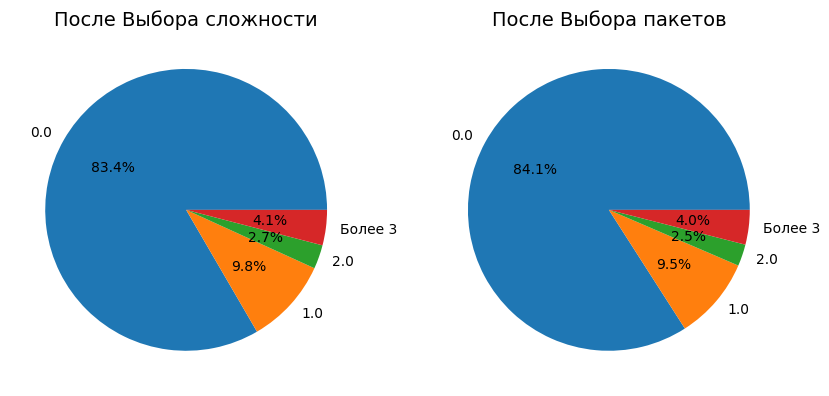

In [35]:
#Находим все первые Выбори сложности
user_first_level_ch = total_events_df[total_events_df['event_type'] == 'level_choice'].groupby('user_id', as_index=False)['start_time'].min()
user_first_level_ch = user_first_level_ch.rename(columns={'start_time':'first_lv_ch_date'})
#Находим для этих пользователей старты и начала обучений
users_tutorials_w_lev_ch = total_events_df[ (total_events_df['event_type'] == 'tutorial_start') 
                                            | (total_events_df['event_type'] == 'tutorial_finish')
                                            ].merge(user_first_level_ch, on='user_id', how='left')
#Считаем кол-во обучений у которых дата начала даты начала Выбор сложности
tutorials_start_count_af_lv_ch = users_tutorials_w_lev_ch[ (users_tutorials_w_lev_ch['start_time']>users_tutorials_w_lev_ch['first_lv_ch_date']) 
                                                  & (users_tutorials_w_lev_ch['event_type'] == 'tutorial_start')
                                                  ].groupby('user_id', as_index=False)['tutorial_id'].count()
tutorials_start_count_af_lv_ch = tutorials_start_count_af_lv_ch.rename(columns={'tutorial_id': 'tutorials_count'})
#Соединяем датасет с Выборами сложности и подсчет кол-ва обучений
user_first_level_ch = user_first_level_ch.merge(tutorials_start_count_af_lv_ch, on='user_id', how='left')
user_first_level_ch['tutorials_count'] = user_first_level_ch['tutorials_count'].fillna(0)
user_first_level_ch['tutorials_count'] = user_first_level_ch['tutorials_count'].apply(lambda x: x if x<3 else 'Более 3')

#Аналогичные дествия проводим для пользователей после Выбора пакета

user_first_pack_ch = total_events_df[total_events_df['event_type'] == 'pack_choice'].groupby('user_id', as_index=False)['start_time'].min()
user_first_pack_ch = user_first_pack_ch.rename(columns={'start_time':'first_pck_ch_date'})
users_tutorials_w_pck_ch = total_events_df[ (total_events_df['event_type'] == 'tutorial_start') 
                                            | (total_events_df['event_type'] == 'tutorial_finish')
                                            ].merge(user_first_pack_ch, on='user_id', how='left')
tutorials_start_count_af_pck_ch = users_tutorials_w_pck_ch[ (users_tutorials_w_pck_ch['start_time']>users_tutorials_w_pck_ch['first_pck_ch_date']) 
                                                  & (users_tutorials_w_pck_ch['event_type'] == 'tutorial_start')
                                                  ].groupby('user_id', as_index=False)['tutorial_id'].count()
tutorials_start_count_af_pck_ch = tutorials_start_count_af_pck_ch.rename(columns={'tutorial_id': 'tutorials_count'})
user_first_pack_ch = user_first_pack_ch.merge(tutorials_start_count_af_pck_ch, on='user_id', how='left')
user_first_pack_ch['tutorials_count'] = user_first_pack_ch['tutorials_count'].fillna(0)
user_first_pack_ch['tutorials_count'] = user_first_pack_ch['tutorials_count'].apply(lambda x: x if x<3 else 'Более 3')

# Строим график
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].pie(
    user_first_level_ch.groupby('tutorials_count')['user_id'].count(),
    labels=user_first_level_ch.groupby('tutorials_count')['user_id'].count().index,
    autopct='%1.1f%%'
);
axes[0].set_title('После Выбора сложности', fontsize=14)

axes[1].pie(
    user_first_pack_ch.groupby('tutorials_count')['user_id'].count(),
    labels=user_first_pack_ch.groupby('tutorials_count')['user_id'].count().index,
    autopct='%1.1f%%'
);
axes[1].set_title('После Выбора пакетов', fontsize=14)


#### Выводы по гипотезе №3
Из графика видно, что менее **20%** пользователей проходят обучение повтороно после выбора сложности или полсе выбора пакетов. Возможно этих пользователей не устраивает цена пакетов и они проходят обучение заново. Также низкий процент повторных прохождений обучения говорит о том, что игра достаточно прозрачна для пользователей 
***